In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

## Load our training dataset and pretrained CNN model

In [2]:
data_dir = './data/cifar10'
training_dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [3]:
len(training_dataset)

50000

In [4]:
random_seed = 42
torch.manual_seed(random_seed);

In [5]:
val_size = 5000
train_size = len(training_dataset) - val_size

train_ds, val_ds = random_split(training_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [49]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Linear(64, 10)) # this is the final CNN layer before classification prediction 
                                # (the one produce M features in Mr.Diggans' letter) and in this case M = 10
        
    def forward(self, xb):
        return self.network(xb)

In [9]:
device = get_default_device()
device

device(type='cpu')

In [10]:
model = to_device(Cifar10CnnModel(), device)

In [11]:
model.load_state_dict(torch.load('cifar10-cnn.pth')) # load our pretrained model

<All keys matched successfully>

In [12]:
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

# Extract feature space from intermediate layer just before the final classification layer

In [13]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()

    return hook

In [14]:
model.network[18].register_forward_hook(get_features('18'))

Below are two example images we have from our trainset of 45000 images. We are experimenting to see if we can successfully extract their feature space of the intermediate layer just before the final classification layer. 

In [15]:
img, label = train_ds[40015]

In [16]:
output = model(to_device(img.unsqueeze(0), device))


In [17]:
features['18'].shape

torch.Size([1, 64])

In [18]:
img, label = train_ds[40010]
output = model(to_device(img.unsqueeze(0), device))
features['18']

tensor([[-33.3030,  16.9400, -16.4483, -17.0487,  -9.4894, -12.7982, -12.6007,
          -5.9499,  -6.1150, -14.3367,  -5.3236, -16.0510,  -9.7710, -17.0389,
         -12.0723, -21.7537,  20.9728,  -7.9361,  -9.0360, -15.7313,  17.9564,
         -18.9220,  27.0687, -10.2720, -14.4215,  25.5399,  -4.8923,   5.2339,
         -14.4592, -17.0238, -12.9081, -17.8656,  20.1692, -12.5104,  10.0218,
          -8.7546,   3.0353, -10.8188,  -5.0133, -12.7305,  -7.6203,  -6.6084,
          -8.5120,  -8.0371,   6.6164,  -8.3862,  -7.2923, -15.4102,  15.4927,
         -13.0282,  -8.5688,   3.2616,   3.6510,  -5.7958,   1.8589, -15.4129,
         -15.0838, -13.0273,  -4.4431, -11.6662,  -8.0818,  -9.0962, -10.6501,
         -13.3178]])

It seems to be successful, so now we can try to extract the feature space of every training image to form a vector. These vectors will then form a huge matrix of the dimension 64 * 45000 to representing the whole training dataset.  

# Build the dataset matrix with feature space (number of rows) of 64 for 45000 image vectors (number of columns)

In [19]:
dataset_matrix = []

for i in range(len(train_ds)):
    img, label = train_ds[i]
    output = model(to_device(img.unsqueeze(0), device))
    dataset_matrix.append(features['18'])

### Below is the matrix (of the dimension 64 * 45000) to represent the whole training dataset of 45000 images

In [20]:
dataset_matrix = torch.cat(dataset_matrix, dim = 0).T 
dataset_matrix

tensor([[-15.2748, -33.5281, -21.3351,  ...,  -5.6529, -23.5119, -15.3105],
        [-13.1279,  -3.9095, -18.1370,  ...,  -1.2432,   2.8258,   7.8583],
        [-19.0318, -25.4091, -21.0193,  ..., -16.0697, -12.8252,  -8.1891],
        ...,
        [-18.8240, -19.4958, -14.0463,  ..., -16.0955, -12.8271, -11.0381],
        [-19.0703, -28.2956, -24.7656,  ..., -17.7981, -16.3135, -20.5031],
        [ -8.6824, -20.5190, -11.5298,  ...,  -7.2010,  -8.4604,  -4.0791]])

In [21]:
dataset_matrix.shape

torch.Size([64, 45000])

In [22]:
len(train_ds)

45000

#### save the feature matrix of the training dataset

In [33]:
pd.DataFrame(dataset_matrix).to_csv(f"C:/Columbia_University/Research/Capstone/Data/trainset_feature.csv", index = False, header = False)

In [26]:
img, label = training_dataset[45555]

In [27]:
img

tensor([[[0.4157, 0.4196, 0.4353,  ..., 0.3882, 0.3843, 0.3804],
         [0.4510, 0.4549, 0.4706,  ..., 0.4000, 0.3961, 0.3922],
         [0.4706, 0.4706, 0.4824,  ..., 0.4078, 0.4039, 0.4000],
         ...,
         [0.8039, 0.8314, 0.8667,  ..., 0.7725, 0.8471, 0.8471],
         [0.8353, 0.8157, 0.8235,  ..., 0.8157, 0.8196, 0.8235],
         [0.8118, 0.8039, 0.8196,  ..., 0.8000, 0.8235, 0.8314]],

        [[0.5922, 0.5961, 0.6118,  ..., 0.5529, 0.5490, 0.5451],
         [0.6118, 0.6157, 0.6314,  ..., 0.5686, 0.5647, 0.5569],
         [0.6196, 0.6196, 0.6314,  ..., 0.5765, 0.5686, 0.5647],
         ...,
         [0.8471, 0.8745, 0.9098,  ..., 0.8039, 0.8824, 0.8824],
         [0.8784, 0.8588, 0.8667,  ..., 0.8510, 0.8588, 0.8627],
         [0.8549, 0.8471, 0.8588,  ..., 0.8392, 0.8667, 0.8824]],

        [[0.7529, 0.7529, 0.7725,  ..., 0.7294, 0.7333, 0.7373],
         [0.7804, 0.7843, 0.8000,  ..., 0.7451, 0.7490, 0.7529],
         [0.7922, 0.7882, 0.8000,  ..., 0.7529, 0.7569, 0.

In [28]:
label

9

### This following function helps us to randomly select certain number of images from each class in the training set.

In [34]:
def subsample(trainset, num_images_per_class = 500):
    
    selected_indices_per_class = {i: [] for i in range(10)}


    for index, (image, label) in enumerate(trainset):
        selected_indices_per_class[label].append(index)

    for class_label in selected_indices_per_class:
        np.random.shuffle(selected_indices_per_class[class_label])


    selected_indices = []
    for class_label in selected_indices_per_class:
        selected_indices.extend(selected_indices_per_class[class_label][:num_images_per_class])

    
    selected_images = [trainset[index][0] for index in selected_indices]

    return selected_indices, selected_images

## Extract feature space of 200 randomly selected subsamples (equally selected from each class) and save them locally

No need to execute the cell below every time if we already have enough subsamples

In [ ]:
for i in range(200):
    selected_indices, selected_images = subsample(training_dataset)
    print(len(selected_images))
    intermediate_features = []
    for img in selected_images:
        output = model(to_device(img.unsqueeze(0), device))
        intermediate_features.append(features['18'])

    intermediate_features = torch.cat(intermediate_features, dim = 0).T 
    pd.DataFrame(intermediate_features).to_csv(f"C:/Columbia_University/Research/Capstone/Data/intermediate_feature{i}.csv", index = False, header = False)
    pd.DataFrame({'imgIndex': selected_indices}).to_csv(f"C:/Columbia_University/Research/Capstone/Data/index_{i}.csv", index = False)
    # We need to store the indices of images in order for us to retrieve those images from the training set. These images will be used later to 
    # retrain the CNN and confirm we get the these exact images 

## Load the matrices of feature space back and apply SVD and BSIE on them

In [73]:
from BSI_Entropy import BSIE
Entropy = {}
for i in range(200):
    feature_matrix = pd.read_csv(f"C:/Columbia_University/Research/Capstone/Data/intermediate_feature{i}.csv", header = None)
    U, S, V = torch.svd(torch.tensor(feature_matrix.values))
    key = f"subsample_{i}"
    Entropy[key] = BSIE(S).item()

#### That is, we save all the entropy values of all the subsamples in one dictionary

In [74]:
Entropy

{'subsample_0': 0.06525616774755605,
 'subsample_1': 0.06601550184495408,
 'subsample_2': 0.06583738878277523,
 'subsample_3': 0.06588003418194033,
 'subsample_4': 0.06621561346191263,
 'subsample_5': 0.06609114640029734,
 'subsample_6': 0.06524106166743482,
 'subsample_7': 0.0662361586657545,
 'subsample_8': 0.06550520598930898,
 'subsample_9': 0.06558301145228662,
 'subsample_10': 0.06376776601196743,
 'subsample_11': 0.06543490442498667,
 'subsample_12': 0.06540695499814186,
 'subsample_13': 0.06390118766740938,
 'subsample_14': 0.0660047469238616,
 'subsample_15': 0.06555204454416985,
 'subsample_16': 0.06479973599034716,
 'subsample_17': 0.06548055490708249,
 'subsample_18': 0.06493505076885586,
 'subsample_19': 0.06514160543903769,
 'subsample_20': 0.06589275088330471,
 'subsample_21': 0.06387354818425373,
 'subsample_22': 0.06672664647062265,
 'subsample_23': 0.0647495647314984,
 'subsample_24': 0.06601403724663168,
 'subsample_25': 0.06550203445559888,
 'subsample_26': 0.067573

### Attain the entropy value of the whole CIFAR-10 training set

In [76]:
trainset_matrix = pd.read_csv(f"C:/Columbia_University/Research/Capstone/Data/trainset_feature.csv", header = None)
U, S, V = torch.svd(torch.tensor(trainset_matrix.values))
entropy_value = BSIE(S).item()
print(entropy_value)

0.0654302882809098


### Plot the subsample entropy values

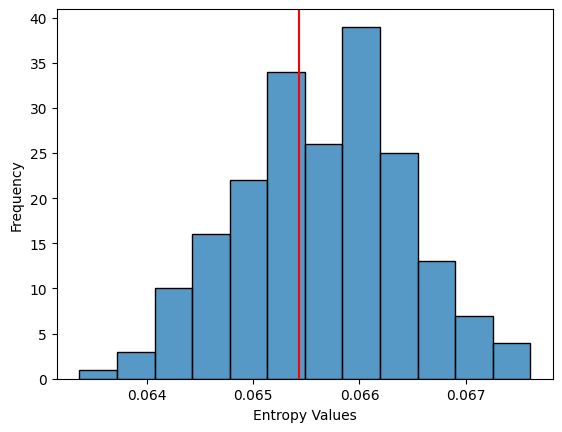

In [82]:
ax = sns.histplot(list(Entropy.values()))
ax.axvline(x = entropy_value, color = 'red', label = "CIFAR-10 Training Set Entropy value")
plt.xlabel("Entropy Values")
plt.ylabel("Frequency");